## Data Science Principles for SEO Testing

---

## Before running all cells, please go to `FILE > Save a copy in Drive` to save the colab notebook to your own Google Drive.

## What if?

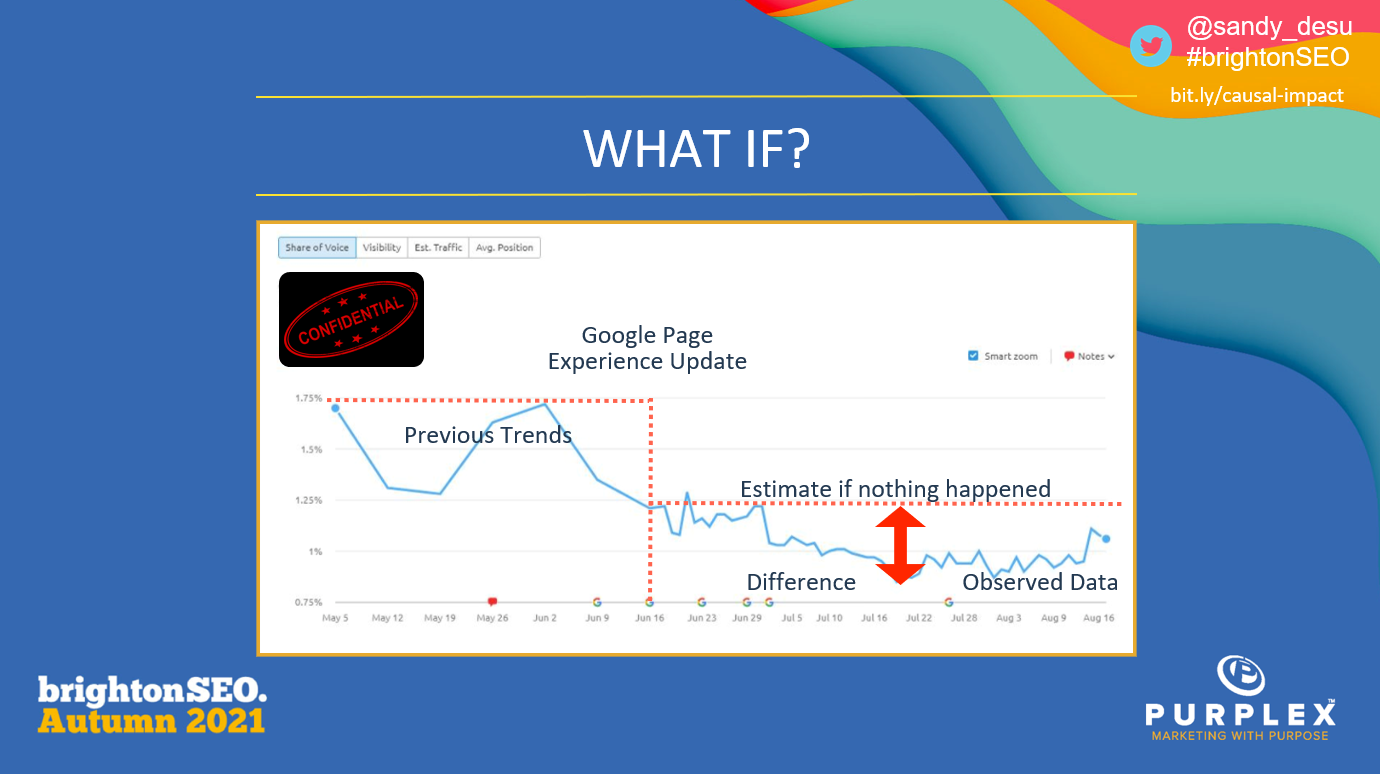

- This was one of our clients after a Google Page Experience update in mid-June.

- It looks like we’ve had a decrease in share-of-voice, but did we? Wouldn’t it be interesting to calculate what would have happened if that update hadn’t occurred?

- How would we do that? It would make sense to feed in some information about previous trends before the change and then compute some estimate of what would have happened before the difference we observed.

- If we did that, we would have our estimate if nothing happened, what happened and the difference between them.

- This difference is the most exciting thing in this situation, as we can use it to estimate what happened in a given case and measure something we would not be able to measure without going between different realities.

- This is possible using the Python package Causal Impact, which lets us use the principles of Causal Inference to calculate a Causal Effect.

## What is Causal Inference?

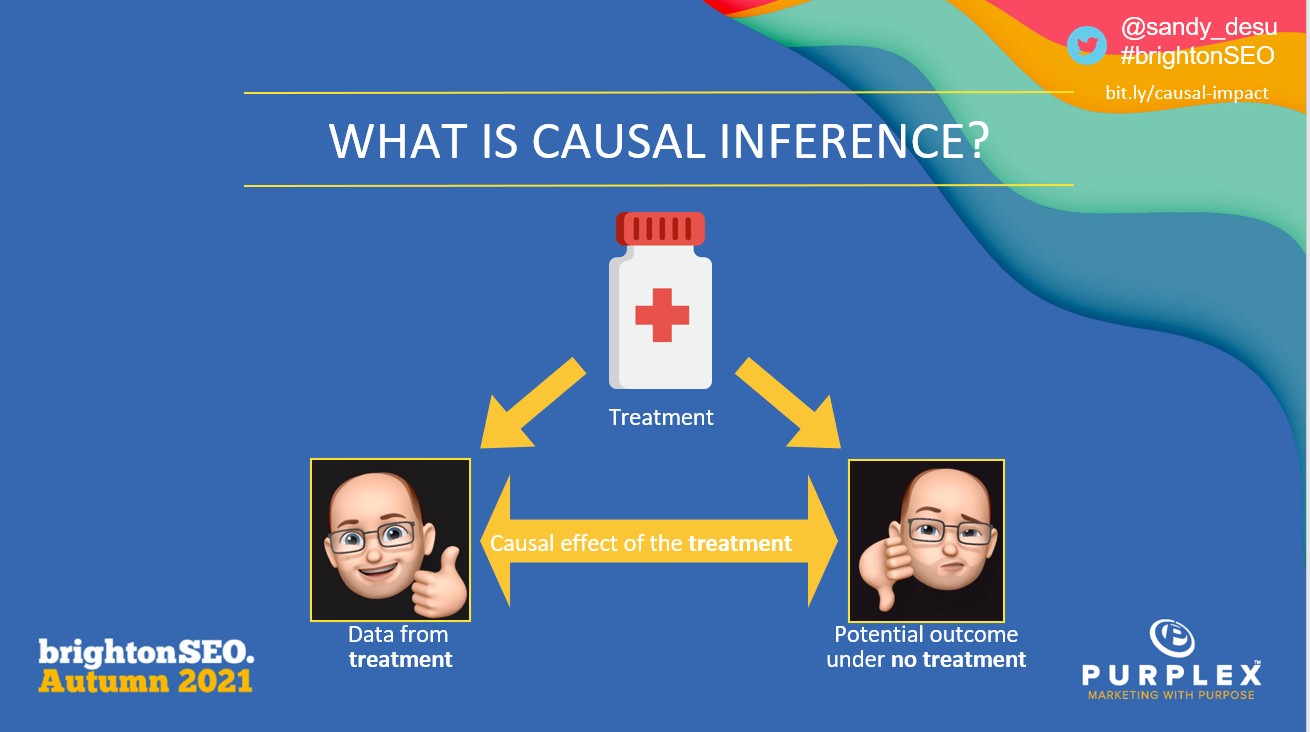

- That change has a name in statistics. It is called a causal effect, and calculating this is called causal inference. We can use it to measure activity or test ideas in SEO or paid media or any time of media activity for that matter.

- We start with a treatment. This treatment can be a product launch, a campaign we’ve launched, a change to some web content or any disruption we have caused to a market.

- What we have is the outcome under the treatment, and this is something we measure in the post period. We will come onto metrics, but this could be something like web clicks.

- We also have the potential outcome under no treatment, and this is something we can calculate by using data from the pre-period as a benchmark.

- The Causal Effect is the difference between the treatment and the potential outcome of no treatment, and this is something we can use to justify if something has had an effect.

## More Complex Example

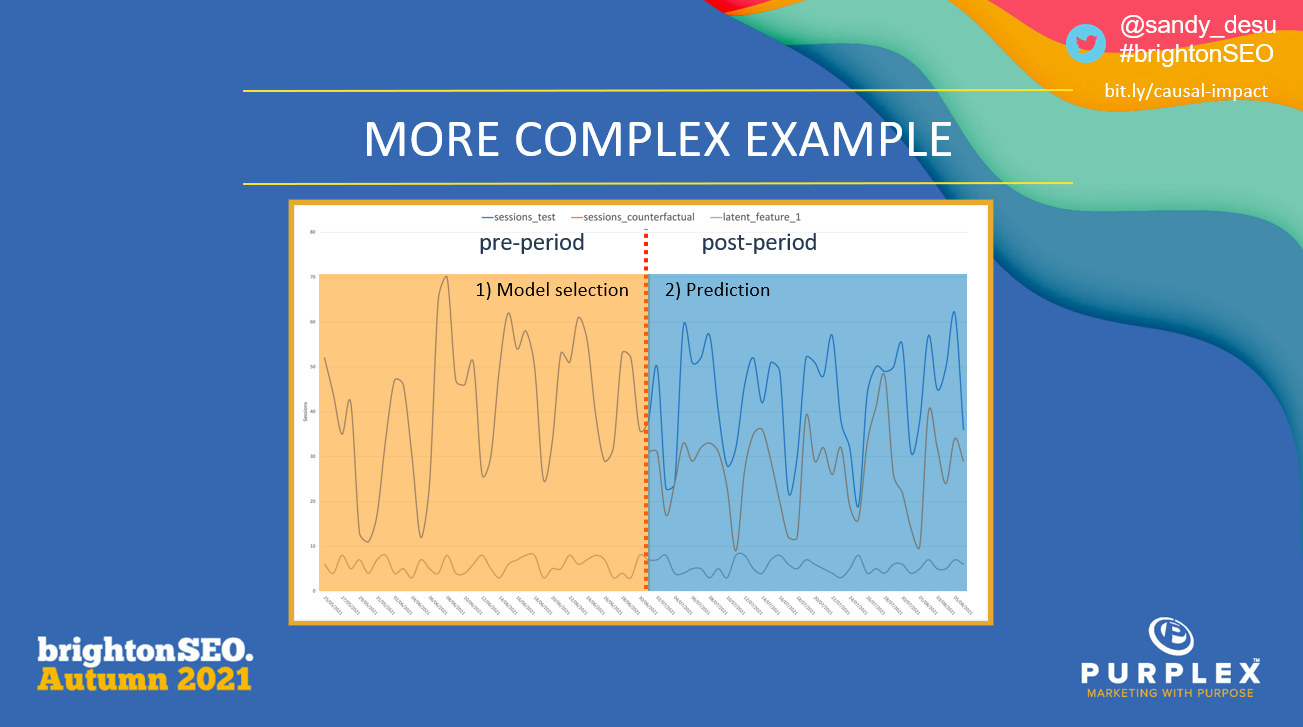

 - This diagram shows sessions versus data with the pre-period and the post-period

- It is hard to tell from this data if the treatment has an effect and how much. It would be handy to establish if it did and, if so, by how much. In other words, what the causal effect is. In the language of causal inference, this is known as the counterfactual.

- Now the way Causal Impact does this is by taking in another time series that is correlated with our data but not affected by the treatment. It takes this data from the latent and runs statistical models on it, and it chooses the best model that best predicts a counterfactual that can be used to measure the causal effect.

## Lets try this ourselves

In this section, I will demonstrate how Causal Impact works with some randomly generated data. I will annotate the code that is important and hide code that isn't important. There are resources at the end of the document that will give some more background on any ideas that may come up here.

In [ ]:
#this command installs the Causal Impact package into our development environment
#for more information in this in a Google Colaboratory environment:
#https://stackoverflow.com/questions/51342408/how-do-i-install-python-packages-in-googles-colab
#in order to set up a Python enviroment locally:
#https://www.tutorialspoint.com/python/python_environment.htm
!pip install pycausalimpact --quiet

In [ ]:
#this command calls the Causal Impact package into memory so it can be used
#https://docs.python.org/3/reference/import.html
import causalimpact as ci

The code block below is a function that randomly generates a toy data set for us to play with to demonstrate how Causal Impact works. You can expand it to take a look, but it isn't important at this stage to fully understand how Causal Impact works. You can run the cells without showing them.

In [ ]:
#@title
def give_random_results(number_results:int=0, max_value:int=0,
                        multiplication_factor:float=0,
                        random_seed:int=42) -> list:
    """
    This is a function to generate a random time series, including the ability
    to take a random seed so as to be able give reproduciblity and to add an
    incremental increase to the results if needed.
    """
    import numpy as np
    #import numpy for working with large arrays of data efficiently
    rg = np.random.default_rng(seed=random_seed)
    #create a random number generator with random seed
    data = []
    #create a list for the randomly produced data
    for _ in range(number_results):
        value = rg.integers(0,max_value)
        data.append(value)
    #loop to create random data for the number of days = number_results
    #the data is randomly generated between the range 0 - max_value
    if multiplication_factor !=0:
        for index,array_cell in enumerate(data):
          data[index] += (array_cell*multiplication_factor)
    #if multiplication_factor is not equal to zero then each value in data is
    #multiplied by the multiplication factor
    return data
    #return the randomly generated data to the caller


In [ ]:
#this command imports the Python package Pandas
#this package is useful for dealing with tabular data
#more info here: https://pandas.pydata.org/
import pandas as pd
#this command calls the give_random_results function to generate random
#data for the preperiod for 50 days between the range of 0 - 10
preperiod = pd.DataFrame(give_random_results(50, 10))
#this command calls the give_random_results function to generate random
#data for the postperiod for 50 days between the range of 0 - 10
#we want to show an uplift after the treatment and here we are adding
#an uplift of 50% which is exagerated for demostration purposes
postperiod = pd.DataFrame(give_random_results(50,10,0.5))

In [ ]:
#this line builds our test data, by concatenating 50 days of preperiod data
#and 50 days of postperiod data with an uplift of 50% after the treatment
test_data = pd.concat([preperiod, postperiod]).reset_index(drop=True)

In [ ]:
#this line builds our control data, remember the control data must correlate
#with the test data, but not be effected by the treatment.
#So we have 100 days worth of data with a random seed of 50 so the results
#are different to the test_data. We have no uplift here too.
control_data = pd.DataFrame(give_random_results(100, 10, 0, 50))

In [ ]:
#this line creates the dataset to feed into Causal Impact by joining
#the test_data set and the control_data set into one
model_data = pd.concat([test_data,control_data], axis=1)
model_data.columns = ["test data", "control data"]

The table below shows the format needed to be fed into Causal Impact. The first column is time, days in this case but it can also be dates. Next is the test data and finally is the control data.

In [ ]:
#this line is to show the first 15 results of the model_data set
#the first column is days, with the second and third columns being
#the test data and the control data
model_data.head(15)

test data  control data
0         0.0             7
1         7.0             7
2         6.0             7
3         4.0             8
4         4.0             8
5         8.0             5
6         0.0             2
7         6.0             9
8         2.0             8
9         0.0             2
10        5.0             2
11        9.0             6
12        7.0             6
13        7.0             0
14        7.0             9

The code block below generates the chart. It can be run while being hidden and isn't important for Causal Impact but it is interesting to look at if you'd like.

This chart is showing what the randomly generated dataset looks like (note this is a line-of-best fit as the real data is very noisy). You can see the uplift after the treatment, however if we feed this into Causal Impact, what do we get?

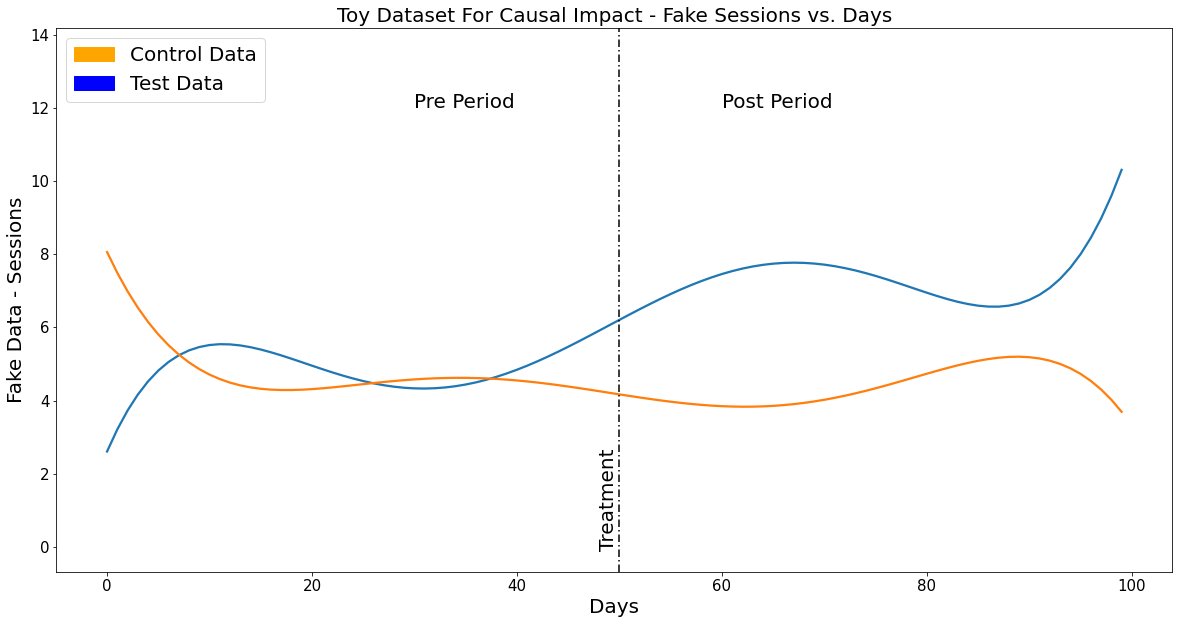

In [ ]:
#@title
#this line imports the library for producing charts
import matplotlib.pyplot as plt
#this like imports Seaborn which is used for making regression lines look pretty
import seaborn as sns
#this line imports mpatches which is used to make the legends on matplotlib charts
import matplotlib.patches as mpatches
#the following line sets up a plot for both the test_data and the control_data
fig, ax = plt.subplots(figsize=(20,10))
#the following line plots a line-of-best fit for our test_data
test_data_line = sns.regplot(data=test_data, x=test_data.index, y=test_data[test_data.columns[:]], order = 5, marker = "", ci = None, label="Test Data")
#the following line plots a line-of-best fit for our control_data
control_data_line = sns.regplot(data=test_data, x=control_data.index, y=control_data[test_data.columns[:]], order = 5, marker = "", ci = None, label="Control Data")
#the following line creates the legend entry for out test_data
blue_patch = mpatches.Patch(color='blue', label='Test Data')
#the following line creates the legend entry for out control_data
orange_patch = mpatches.Patch(color='orange', label='Control Data')
#the following line plots the legend on the chart
plt.legend(handles=[orange_patch, blue_patch], fontsize = 20)
#the following line sets the title on the x-axis
plt.xlabel("Days", fontsize = 20)
#the following line sets the title on the y-axis
plt.ylabel("Fake Data - Sessions", fontsize = 20)
#the following line sets the font size for the numbers on the x and y axis
ax.tick_params(labelsize=15)
#the following line sets the title for the whole chart
plt.title('Toy Dataset For Causal Impact - Fake Sessions vs. Days', fontsize = 20)
#the following line plots the vertical dashed line in the middle of the chart
plt.axvline(x=50, color='black', dashes=(5, 2, 1, 2))
#the following line sets the label for the 'treatment'
plt.text(48,0.01,'Treatment', rotation=90, fontsize=20)
#the following line sets the label for the 'pre period'
plt.text(30,12,'Pre Period', fontsize=20)
#the following line sets the label for the 'post period'
plt.text(60,12,'Post Period', fontsize=20);



In [ ]:
#Here we are defining the timeperiods for this pre and post period phases. The numbers are the rows in our table, but are not quite days as Python is zero indexed.
pre_period=[0,49]
post_period=[50,99]

In [ ]:
#Here we are defining a Causal Impact model by feeding in the data table above in the correct form and highliughting the columns we want
#as well as defining the preperiod and post period timeframees.
model = ci.CausalImpact(model_data[model_data.columns[0:2]],pre_period,post_period)

The **plot()** command shows the results of the model in chart form. The chart below is easy to interpret with practice. The first chart shows the result of the experiment as well as the result predicted by the model. The dashed line in the middle is the point where the treatment happened. The solid black line shows the results obtained. The purple dashed line shows the counterfactual predicted by the model, and the purple shaded area shows the confidence interval.

For a full explanation of the confidence interval, look [here](https://www.simplypsychology.org/confidence-interval.html). The narrower the confidence interval, the more certain of our results we can be. The confidence interval should always be a sign of quality for our experiments.

The second chart shows the point effect of our experiment, which is the result obtained minus the counterfactual. We see here usually results of around zero before the treatment and then a change after the treatment (either an uplift as can be seen below or something else).

The final chart shows the cumulative effect of our test. We made the toy dataset have an uplift after the treatment, and this can be seen in this chart and shows the incremental increase after the treatment. This chart is good at showing whether the treatment had a positive net effect or not.



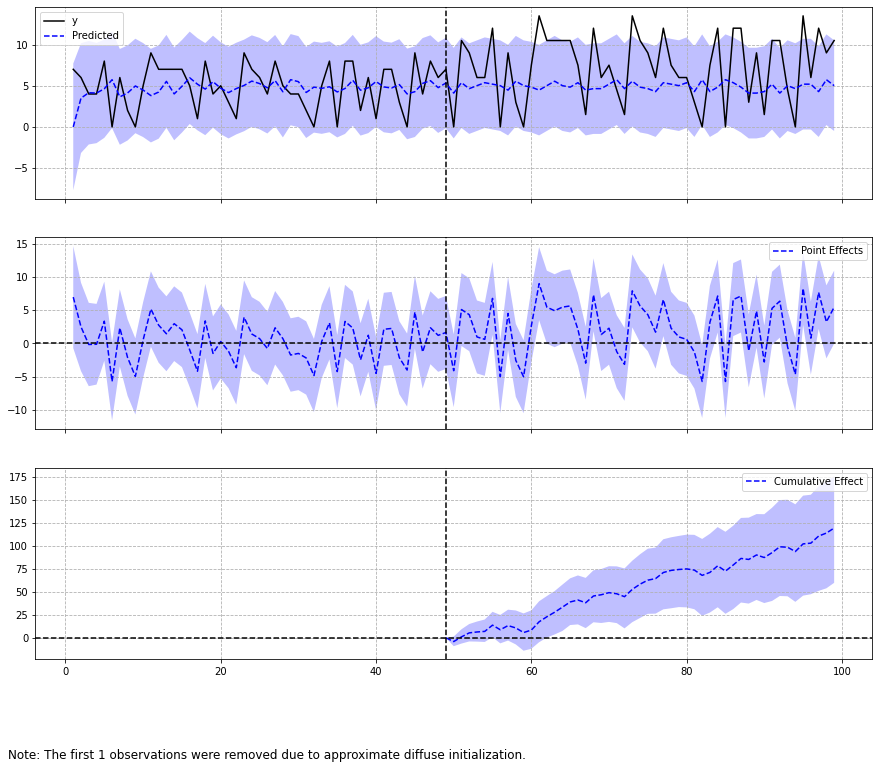

In [ ]:
model.plot()

The **summary()** command prints out a numerical overview of the impact of our experiment. The summary is super helpful, but the numbers aren't always easy to understand and may require explanation.

The **average** column, as the name implies, shows average daily data for the experiment. As the name suggests, the **cumulative** column deals with the cumulative effect after the treatment and is the most helpful column for examining the overall impact of the experiment.

The **Actual** row shows the actual data obtained, both average and cumulative. The **prediction** row shows the model results without treatment (the counterfactual). The number **s.d.** means **standard deviation** and measures the spread of the data around the average (smaller-the-better).

The **95%CI** shows the results for a 95% confidence interval. This is saying that we are 95% certain that the result lies somewhere between the range given in the interval. The narrower the confidence interval, the better. However, it is still worth bearing in mind that there is a 5% chance we could be wrong (welcome to statistics - **woohoo!**)

The **absolute effect** columns show the experiment results based upon any incremental effect between the prediction and the actual results obtained.

The **relative effect** shows the experiment results based upon all of the results obtained as part of the experiment.

The **posterior tail-area probability p** is a statistical measure of how certain we are that seeing the effect didn't happen by chance. For a full explanation, see [here](https://stats.stackexchange.com/questions/263763/what-does-posterior-tail-area-probability-mean-in-causal-impact), but the lower this number is, the better.

The **posterior prob. of a causal effect** is self-explanatory, but the higher this number is, the better, with 100% being the best result.

In [ ]:
print(model.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    7.32               366.0
Prediction (s.d.)         4.93 (0.59)        246.5 (29.58)
95% CI                    [3.8, 6.12]        [190.19, 306.16]

Absolute effect (s.d.)    2.39 (0.59)        119.5 (29.58)
95% CI                    [1.2, 3.52]        [59.84, 175.81]

Relative effect (s.d.)    48.48% (12.0%)     48.48% (12.0%)
95% CI                    [24.28%, 71.32%]   [24.28%, 71.32%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


By using the **summary('report')** command we get a more detailed written explanation of the results of the experiment. A lot of the language used in this explanation is the same as in the **summary()**, but it should provide more detail in an accessible way.

In [ ]:
print(model.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 7.32. By contrast, in the absence of an
intervention, we would have expected an average response of 4.93.
The 95% interval of this counterfactual prediction is [3.8, 6.12].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 2.39 with a 95% interval of
[1.2, 3.52]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 366.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 246.5. The 95% interval of this prediction is [190.19, 306.16].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a

##How much data do we need for a valid experient?

This is an interesting question and one that experience will answer. However, as a starting point, it is worth remembering that as much data as you can get is better. However, there is an element of time to this because if it takes too long to get data, then the results may well be useless due to a lack of timeliness.

For example, if we look at the results of the above toy dataset, but over 1,000 days instead of 100, we see that the confidence intervals around all three charts are narrower (i.e. we can be more confident of the results). However, if it takes 1,000 days to get the results of an experiment (i.e. three years) that we trust, it is of little actionable value.

When thinking about how much data you need to get results, consider:

i) Start with at least one month and see the results you get

ii) Always look at the confidence intervals as this is a good guide, and the model will tell you if it can't be confident of any definitive results with the data we have

iii) Balance this against time. If it takes too long to get definitive results, then the experiment may not be worth it.

In [ ]:
#@title
preperiod_1000 = pd.DataFrame(give_random_results(500, 10))
postperiod_1000 = pd.DataFrame(give_random_results(500,10,0.5))
test_data_1000 = pd.concat([preperiod_2, postperiod_2]).reset_index(drop=True)
control_data_1000 = pd.DataFrame(give_random_results(1000, 10, 0, 50))
model_data_1000 = pd.concat([test_data_2,control_data_2], axis=1)
model_data_1000.columns = ["test data", "control data"]
pre_period=[0,499]
post_period=[500,999]
model_1000 = ci.CausalImpact(model_data_2[model_data.columns[0:2]],pre_period,post_period)

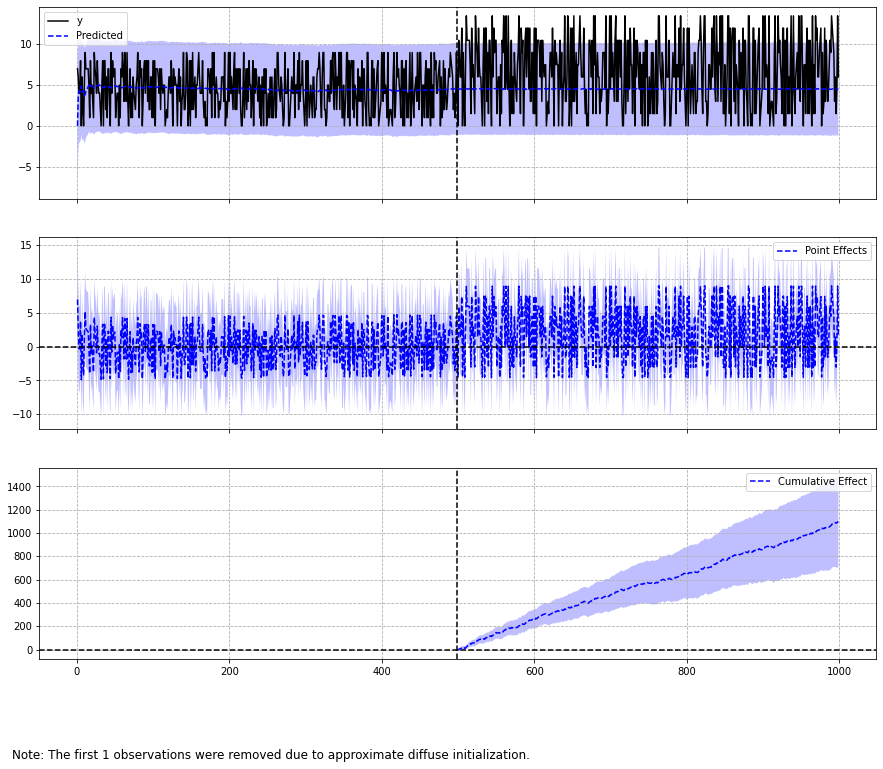

In [ ]:
model_1000.plot()

##Tips for running your own experiments

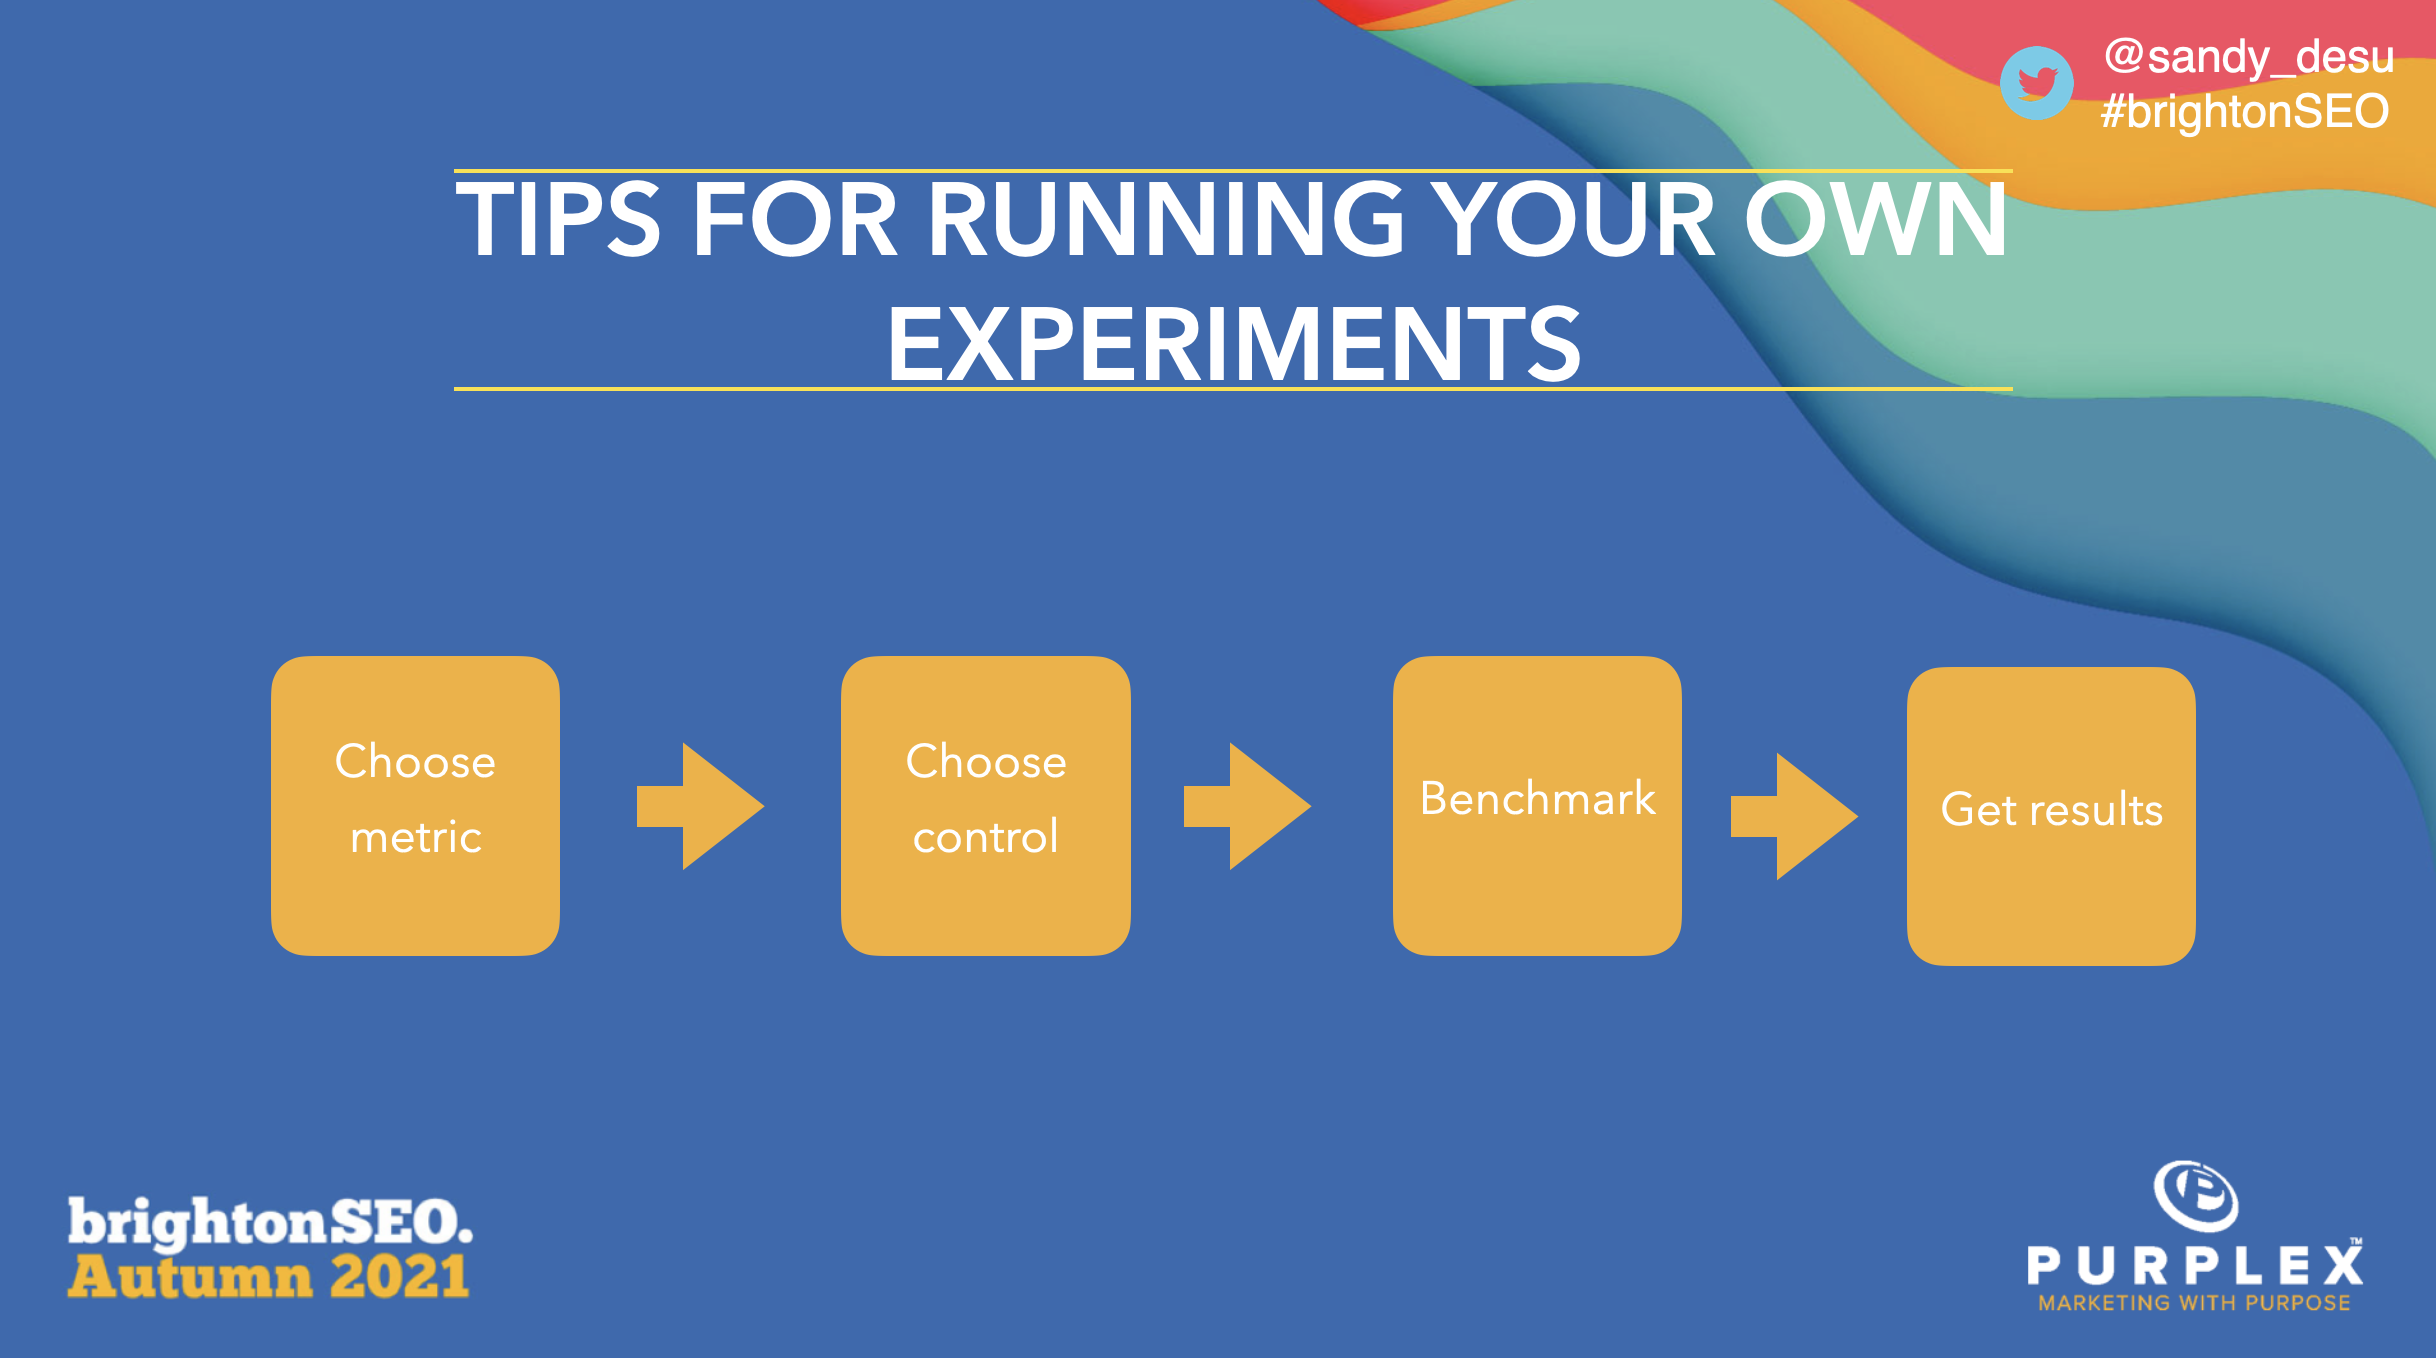

In [ ]:
##Choose Metrics, Beware Spurioud Correlations!

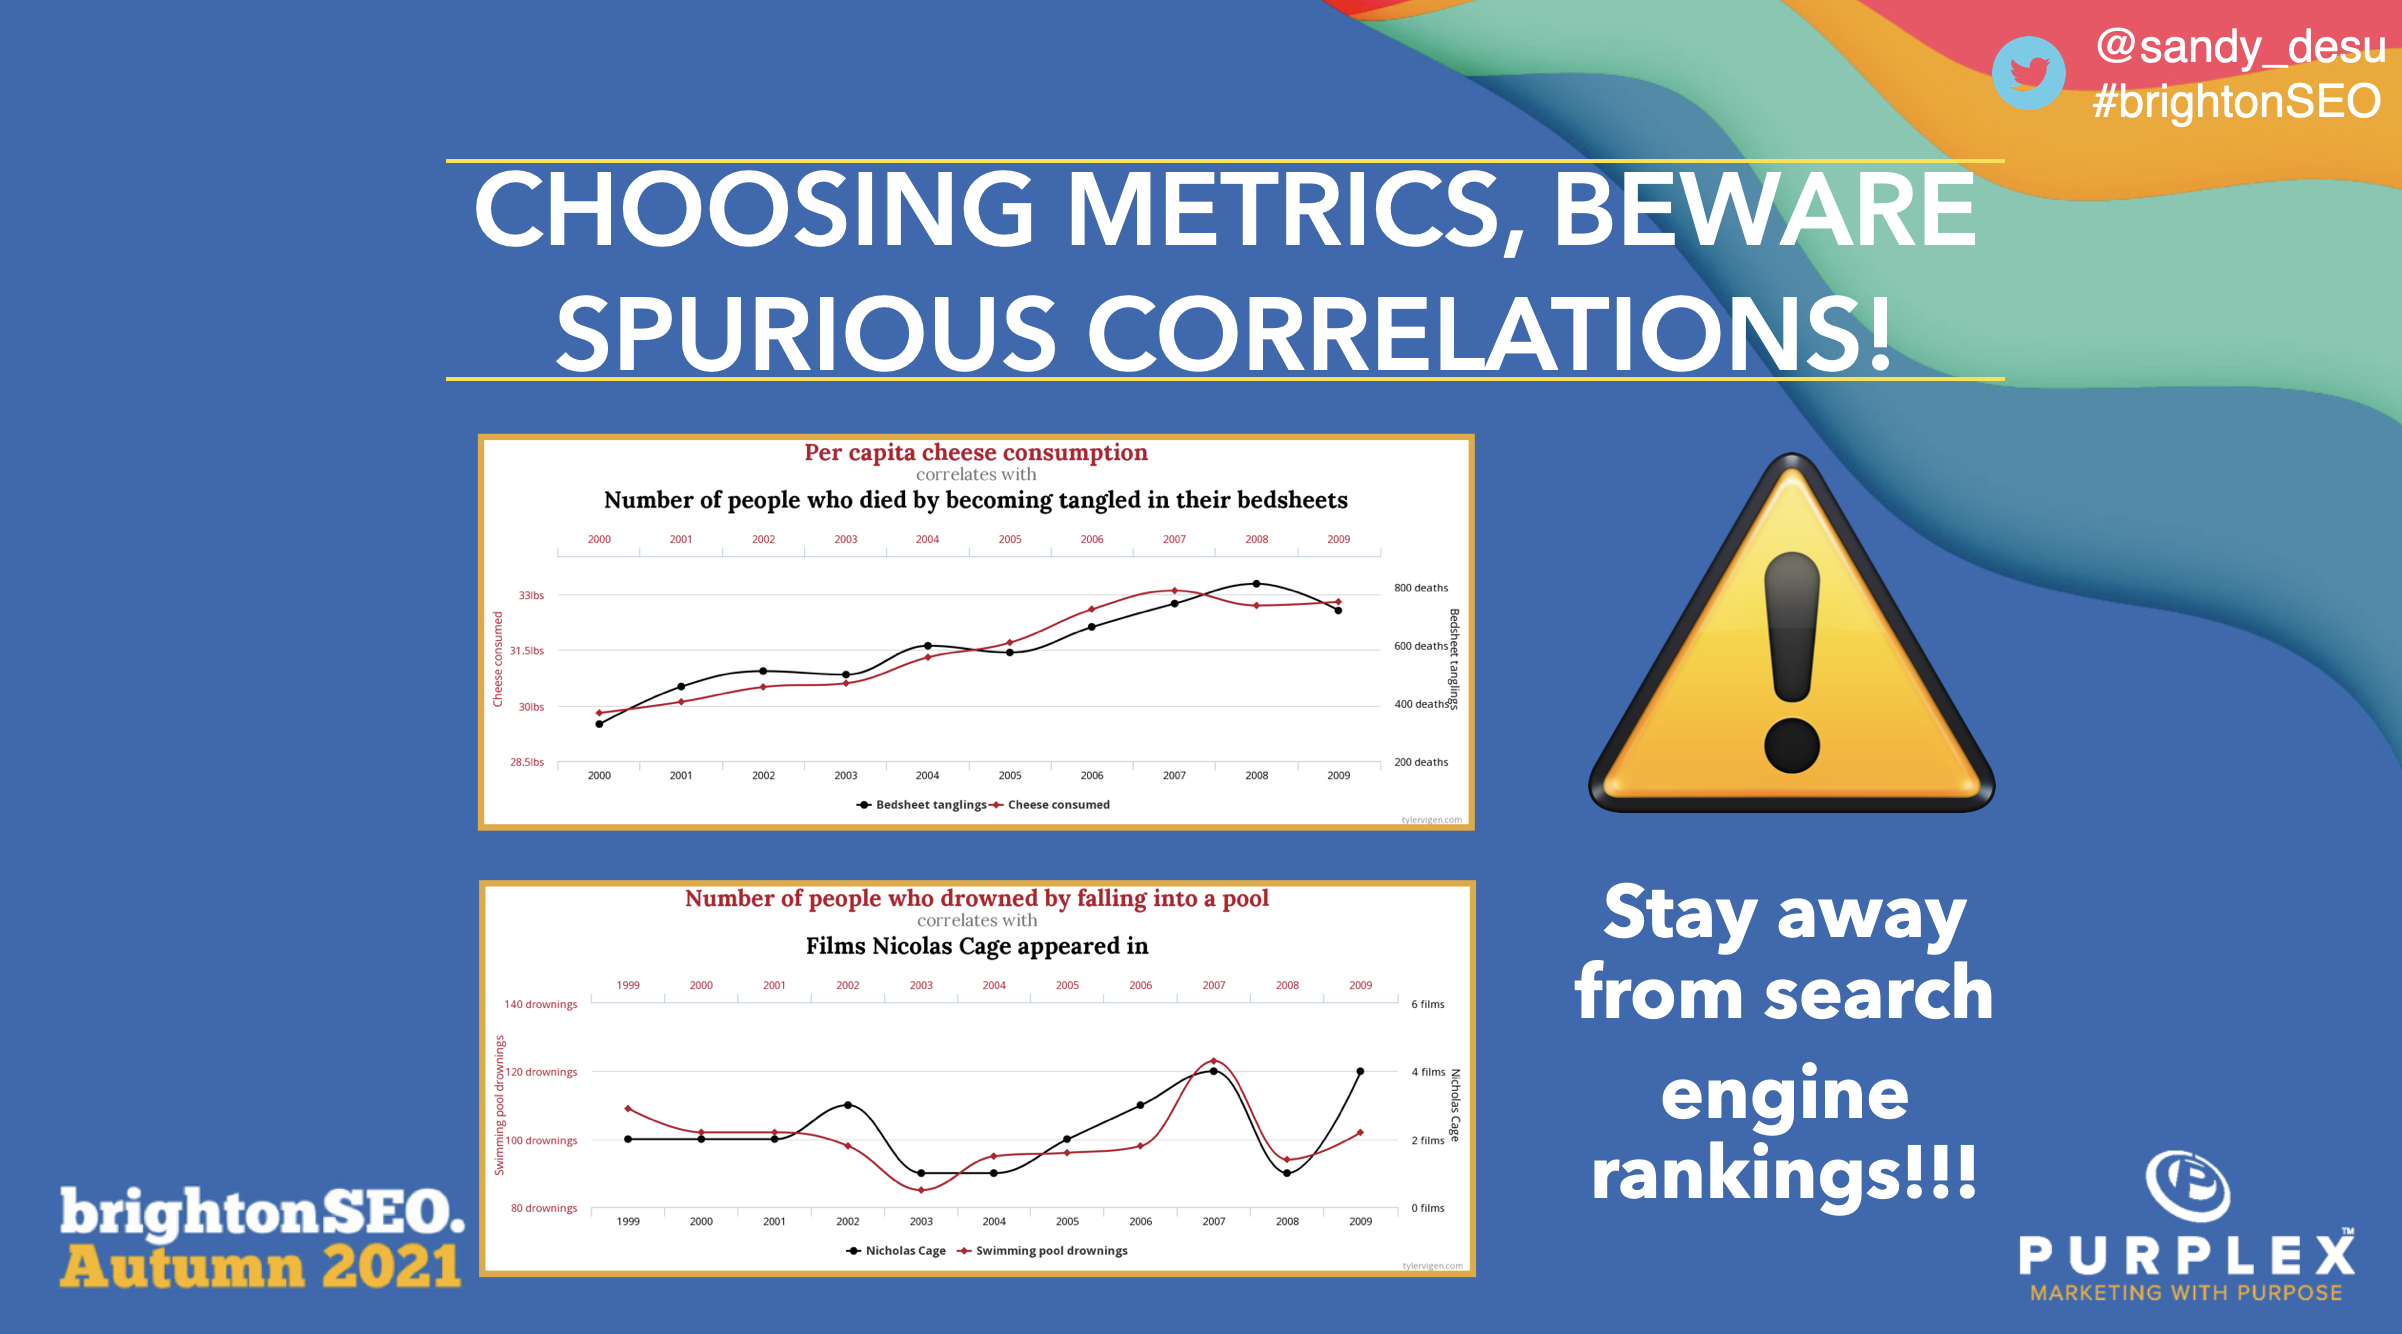

You can use almost any metrics within reason, but I advise you to keep it simple: clicks, sessions, and sign-ups are the obvious three.
- Whatever you choose for your control, they must be correlated with the effect you are measuring, and there isn't a lot in SEO that doesn't correlate with clicks, sessions and sign-ups.
- If going outside of this, beware of spurious correlations.
An example of this is if you are selling Xmas puddings and you reduce their price as a treatment. You want to know if that has an effect, you have six months of data in your pre-period showing not many sales, but then you have a spike in December as a post-period. Is this because of your offer or the fact it is Christmas?
- You can control for this with common sense and and more data in the pre-period

##Choosing Your Control Group, Different But Same

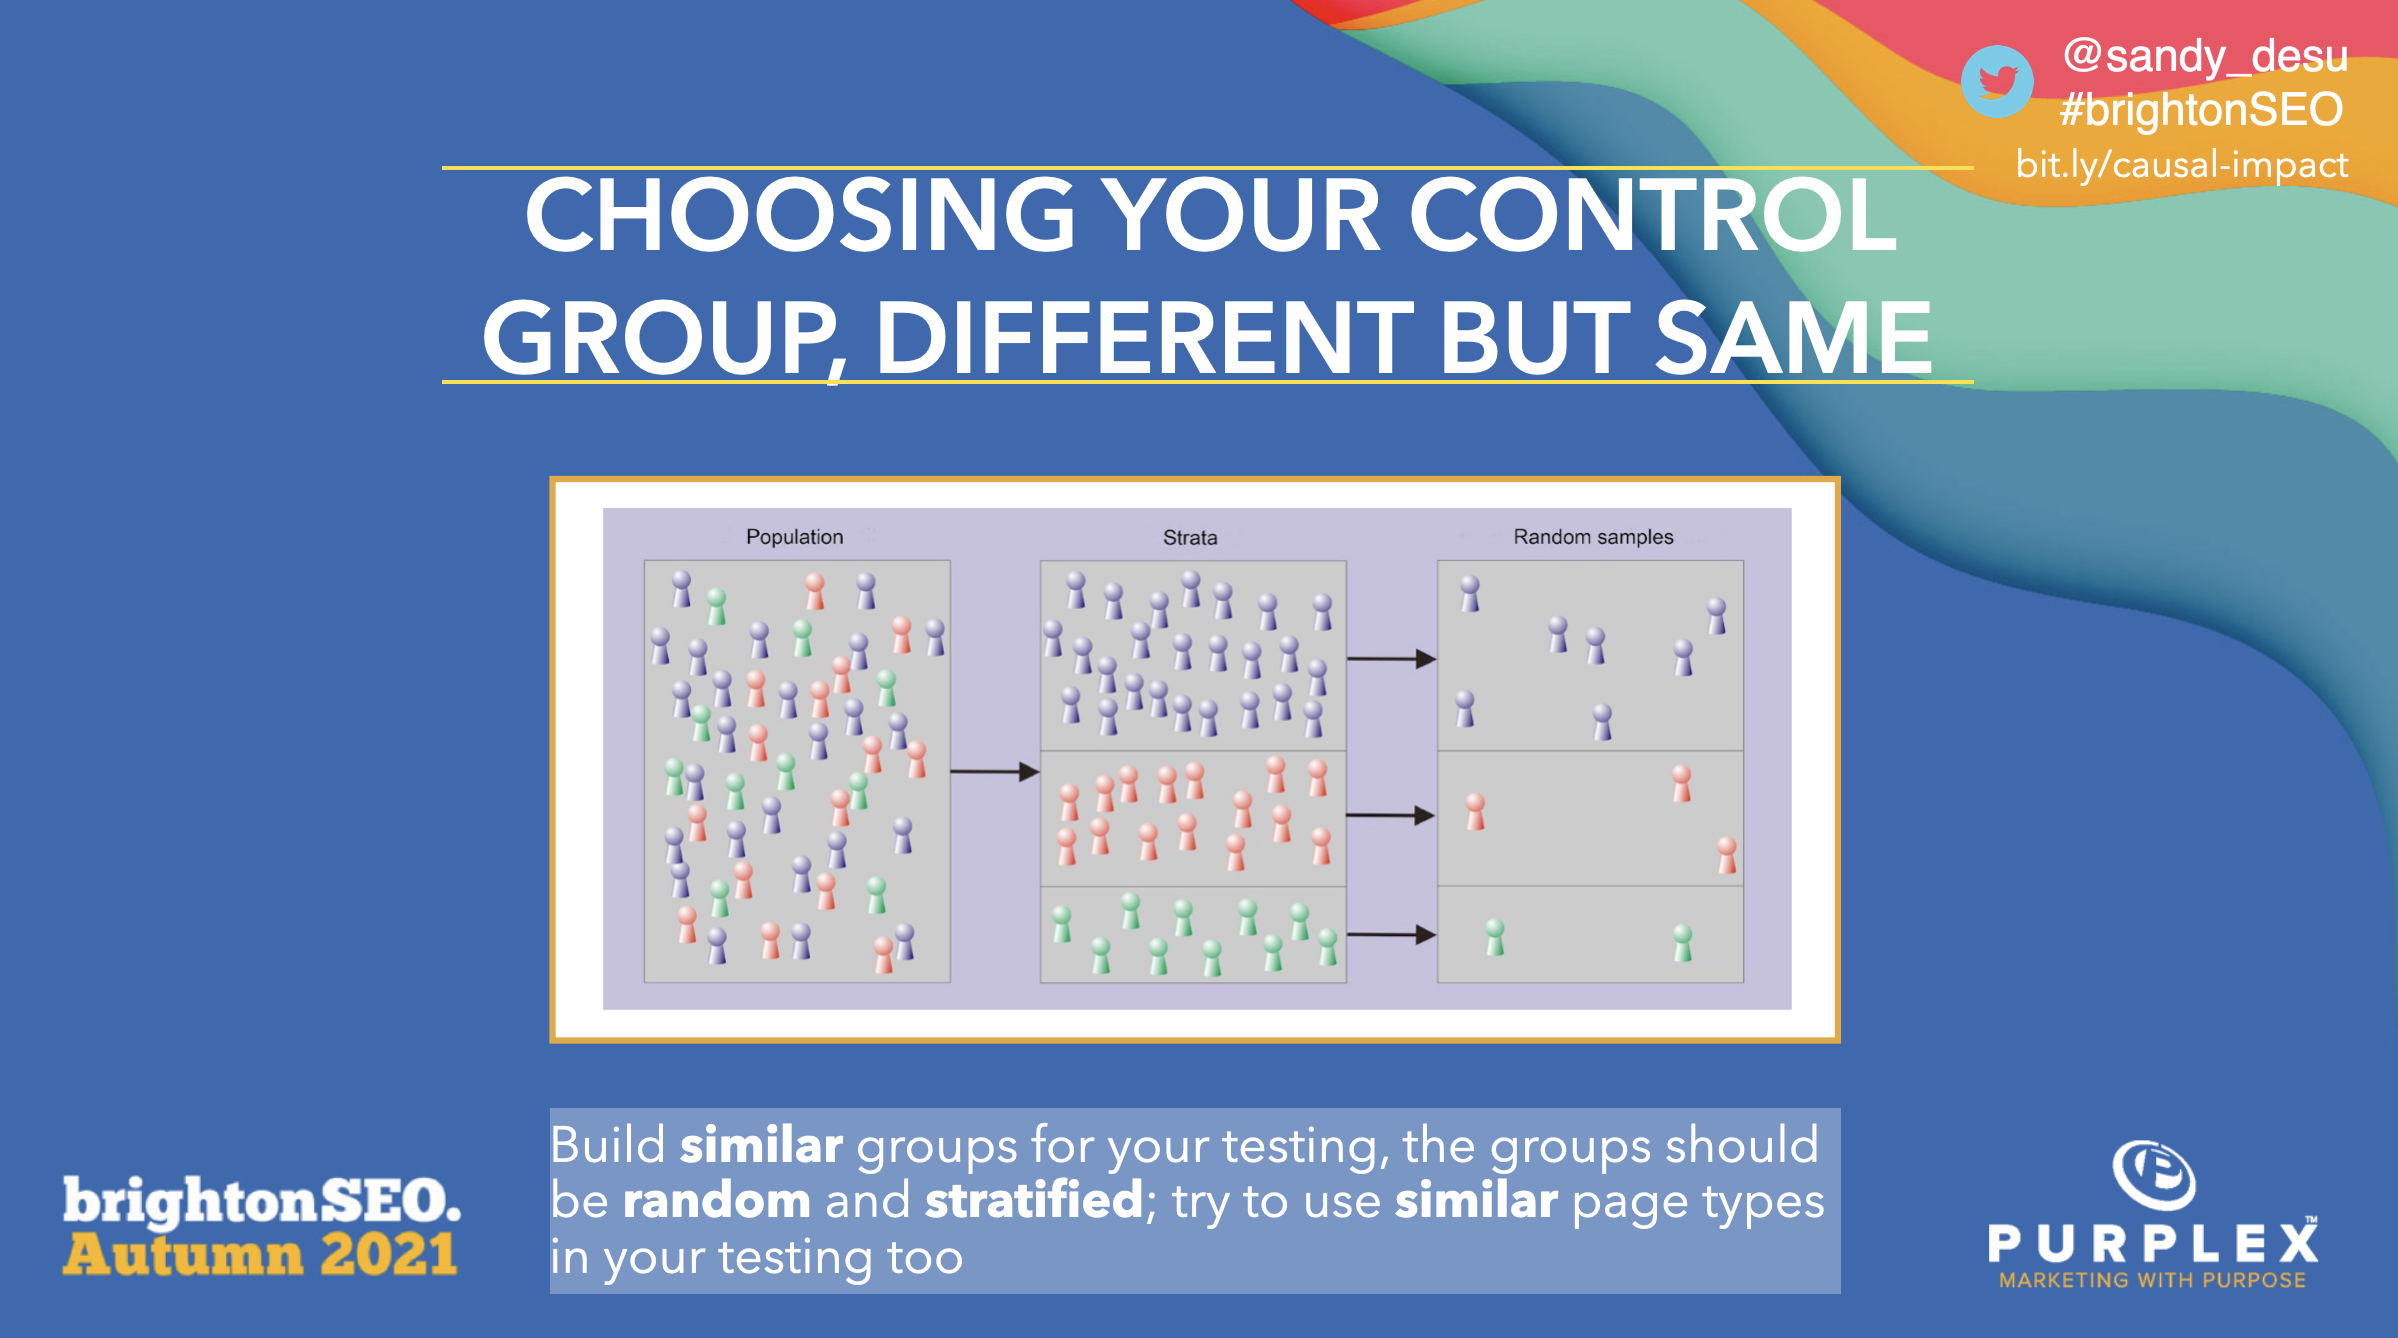

- Choosing a suitable control group is essential for a good experiment.
- There are principles behind this that can get very advanced. For an idea of this, see [here](https://www.qualtrics.com/experience-management/research/stratified-random-sampling/). This is what a typical statistical test looks like, i.e. randomised testing from a population.
- As a good starting point, it is best to remember that the control group you choose must be correlated with the test group but not affected by the treatment. An easy way for a large website is to pick a similar section of the site that isn't in the test and use that as a control. For a smaller website, use the whole site that isn't in the test as a control.



##Try this for yourself

To try this for yourself, you first need to put the data into a CSV with the first column having the test data and the second column having the control data. Each row is one days worth of data and an example can be seen below:

The first column is the test data. The second column is the control data. Name this file "model_data.csv" and upload it to [Google Colab](https://colab.research.google.com/notebooks/io.ipynb) and then run the following cells.

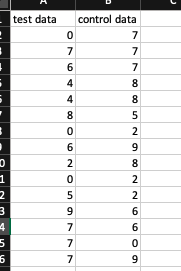

In [ ]:
import causalimpact as ci
import pandas as pd
model_data = pd.read_csv("model_data.csv")

In [ ]:
pre_period=[0,49] #define the number of days for your pre-period here, remember Python is zero indexed, so day 1 will be actuall be zero
post_period=[50,99] #define yhr number of days for your post-period here

In [ ]:
model = ci.CausalImpact(model_data[model_data.columns[0:2]],pre_period,post_period)  #this runs the model

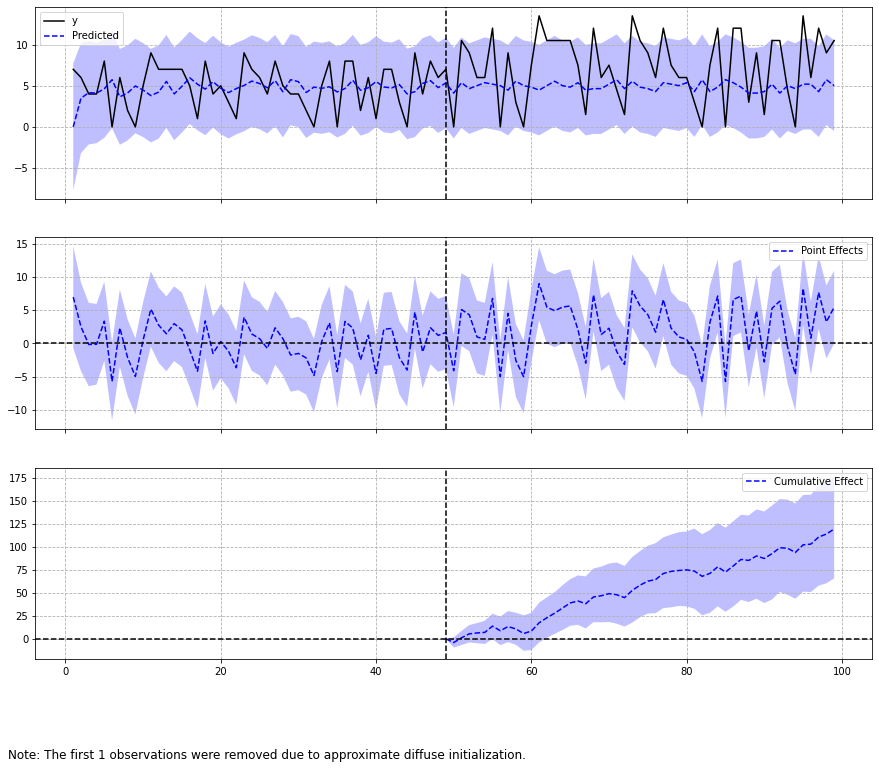

In [ ]:
model.plot()  #shows the model plot

In [ ]:
print(model.summary()  #print model summary

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    7.32               366.0
Prediction (s.d.)         4.93 (0.57)        246.5 (28.37)
95% CI                    [3.78, 6.01]       [189.14, 300.36]

Absolute effect (s.d.)    2.39 (0.57)        119.5 (28.37)
95% CI                    [1.31, 3.54]       [65.64, 176.86]

Relative effect (s.d.)    48.48% (11.51%)    48.48% (11.51%)
95% CI                    [26.63%, 71.75%]   [26.63%, 71.75%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
print(model.summary('report'))  #print model report

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 7.32. By contrast, in the absence of an
intervention, we would have expected an average response of 4.93.
The 95% interval of this counterfactual prediction is [3.78, 6.01].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 2.39 with a 95% interval of
[1.31, 3.54]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 366.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 246.5. The 95% interval of this prediction is [189.14, 300.36].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed

##Additional Resources

- [Google's Python Class](https://developers.google.com/edu/python)
- [Beginners Pandas Course](https://www.kaggle.com/learn/pandas)
- [Kay Broderson talking about Causal Impact](https://www.youtube.com/watch?v=GTgZfCltMm8)
- [Etsy Causal Impact Experiment for Dynamix Page Titles](https://codeascraft.com/2016/10/25/seo-title-tag-optimization/)
- [JC Chouinard talking about Causal Impact](https://www.jcchouinard.com/causalimpact/)
- [Paul Shapiro talking about Causal Impact](https://gist.github.com/pshapiro)